# Tarea N2 - Problema 1

Algunos modelos de clasificación buscan implicita o explicitamente separar los datos linealmente, es decir ajustar un hiperplano que separe en 2 subespacios el espacio de las variables, separando ambas clases del _target_. Sin embargo, en la mayoría de los casos reales esto resulta imposible. Esto no significa que no podamos ajustar modelos con estos datos o buscar transformaciones que nos permitan utilizarlos. 
    
![Alt Text](http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.gif) 

[comment]: <> (Swiss Roll)

En esta primera parte de la tarea crearemos manualmente un set de datos categóricos no linealmente separables. Este se conformará de puntos en $\mathbb{R}^2$, pertenecientes a una de dos categorías etiquetadas 0 o 1, los cuales se encuentran "anidados". Probaremos distintas aproximaciones lineales y no lineales y compararemos sus desempeños.


### Paquetes a utilizar

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import KernelPCA
import seaborn as sns
from sklearn import metrics

### 1.a Creado los datos

La función `do_spiral` retorna un conjunto de puntos etiquetados, donde la etiqueta 0 corresponde a puntos siguiendo la primera mitad de un espiral (con un ruido asociado) y la etiqueta 1 los puntos restantes.

Los parámetros de esta función tienen nombres intencionalmente no descriptivos. Analice la función y comente interpretación puede darle a cada uno de los parámetros con respecto a la influencia que tendrán en el set de datos obtenidos. Si lo estima conveniente, cambie el nombre de los parámetros a nombre más descriptivos.

In [10]:
# Función generación de datos

def do_spiral(n_dots = 1000, ns = 0.05, cf = 4, split = 0.3):
    generator = check_random_state(42)
    linspace = np.linspace(0, cf*np.pi, n_dots)                   # Crea vector de 0 a cfpi en n_dots partes
    circle_x = linspace*np.cos(linspace)                          # Calcula el coseno 
    circle_y = linspace*np.sin(linspace)                          # Calcula el seno
    circle_x=circle_x/max(np.max(circle_x),-np.min(circle_x))     # Normalización de los puntos coseno
    circle_y=circle_y/max(np.max(circle_y),-np.min(circle_y))     # Normalización de los puntos seno
    
    # Data con n_dots con cos y sen en cada atributo, se separa en mitad por las etiquetas de 0 y 1
    X = np.vstack(( 
        np.append(circle_x[0:int(0.5*n_dots)], circle_x[int(0.5*n_dots):]),
        np.append(circle_y[0:int(0.5*n_dots)], circle_y[int(0.5*n_dots):])
    )).T      
    
    # Target la mitad 0 y la segunda mitad 1
    y = np.hstack([
        np.zeros(int(n_dots*0.5), dtype=np.intp),
        np.ones(int(n_dots*0.5), dtype=np.intp)
    ])

    # Se le agrega ruido distribuido normal a cada entrada de los ejemplos.
    X += generator.normal(scale = ns, size = X.shape)

    # Retorna x_train, y_train, x_test y y_test con 70% y 30% respectivamente
    return(train_test_split(X, y, test_size=split, random_state=42))

**Comentarios:** 
* La función `di_spiral` genera una serie de `n_dots` puntos de una espira., A dicha data se le agrega un ruido normal para simular una data real, se asigna a la primera mitad `n_dots` la etiqueta de 0 y para la segunda mitad se etiquetan de 1. Finalmente se separa el train y test set en un 70% y 30% respectivamente.

* Básicamente, se crearon una cantidad de puntos entre 0 y cf$\pi$ en `n_dots` partes. Luego, se calcula el $\cos(\theta)$ y $\sin(\theta)$ de cada uno de esos puntos y se multiplican por el punto en cuestión, generando la espiral debido a que el valor de los puntos va aumentando (si fueran constantes, generarían un circulo). Para el target, simplemente se le asigna el valor 0 a la primera mitad y 1 al resto.

* `generator = check_random_state(42)` permite que al dividir los conjuntos, este resultado sea igual en cualquier iteración.

### 1.b Graficar los datos

Cree una función que grafique los datos, coloreando distintamente los puntos de cada clase. Utilice esta función para verificar gráficamente lo que propuso en la pregunta anterior variando cada uno de los parámetro de esta función.

In [11]:
# Función que grafique la data segun N° de puntos, ruido y frecuencia

def graph(n_dots = 1000, ns = 0.05, cf = 4, split = 0.3):

    # Define tamaño de la gráfica
    ig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True,sharex=True)

    # Puntos
    x_tr,x_tst,y_tr,y_tst = do_spiral(n_dots, ns, cf, split)

    # Gráfica Training Set
    axs[0].scatter(x_tr[y_tr == 0][:,0],x_tr[y_tr == 0][:,1])
    axs[0].scatter(x_tr[y_tr == 1][:,0],x_tr[y_tr == 1][:,1]) 
    
    # Gráfica Test Set
    axs[1].scatter(x_tst[y_tst == 0][:,0],x_tst[y_tst == 0][:,1])
    axs[1].scatter(x_tst[y_tst == 1][:,0],x_tst[y_tst == 1][:,1])
    
    # Leyenda por etiqueta
    axs[0].set_title("Training Set")
    axs[0].legend(['Clase 0','CLase 1'])
    axs[1].set_title("Test Set")
    axs[1].legend(['Clase 0','CLase 1'])
    return print('Gráfica para data de', n_dots, 'puntos con ruido normal de desviación estándar', ns)

Gráfica para data de 1000 puntos con ruido normal de desviación estándar 0.05


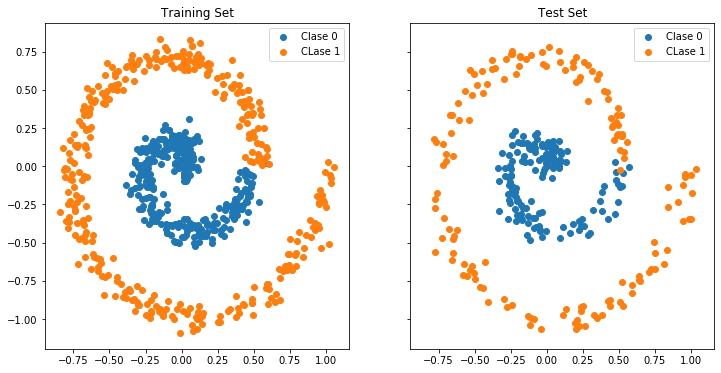

In [12]:
graph(n_dots = 1000, ns = 0.05, cf = 4, split = 0.3)

### 1.c Regresión Logística

Se realiza una regresión logística para 5000 puntos generados con los siguientes parámetros

[1.](#primero) `do_spiral(n_dots = 5000 , ns = 0    , cf = 6)`

[2.](#segundo) `do_spiral(n_dots = 5000 , ns = 0.08 , cf = 6)`

Grafique los datos que está ajustando y calcule el score del regresor logístico en cada caso. ¿Qué valor entrega el score del regresor logístico?¿Le parece un buen desempeño para la tarea a realizar?

In [13]:
# DATOS
x_tr1, x_tst1, y_tr1, y_tst1 = do_spiral(n_dots = 5000, ns = 0, cf = 6)
x_tr2, x_tst2, y_tr2, y_tst2 = do_spiral(n_dots = 5000, ns = 0.08, cf = 6)

Gráfica para data de 5000 puntos con ruido normal de desviación estándar 0


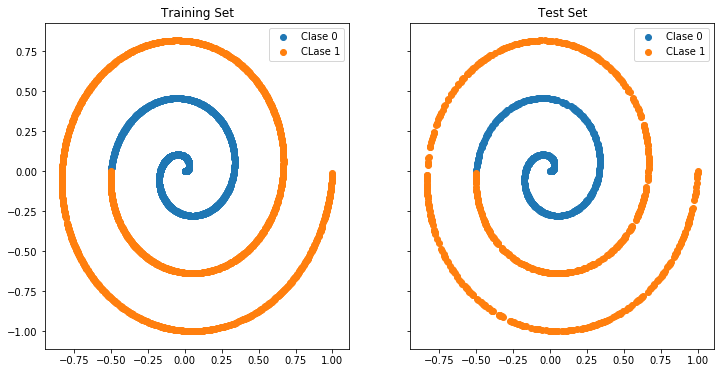

In [14]:
# Gráfica para 1.
graph(n_dots = 5000, ns = 0, cf = 6)

In [15]:
# Ajuste mediante regresión logistica para 1.
log_reg1 = LogisticRegression()
log_reg1.fit(x_tr1,y_tr1)
log_reg1.score(x_tst1,y_tst1)

0.6773333333333333

Gráfica para data de 5000 puntos con ruido normal de desviación estándar 0.08


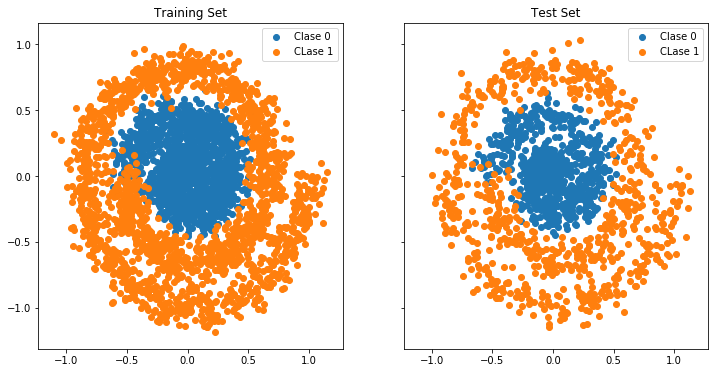

In [16]:
# Gráfica para 2.
graph(n_dots = 5000, ns = 0.08, cf = 6)

In [17]:
# Ajuste mediante regresión logistica para 1.
log_reg2 = LogisticRegression()
log_reg2.fit(x_tr2,y_tr2)
log_reg2.score(x_tst2,y_tst2)

0.6606666666666666

**Comentarios:** el score entrega la precisión que se obtiene utilizando la regresión logística, esta tiene un máximo de 1. 
Se obtiene:
* Score de problema sin ruido: 0.677
* Score de problema con ruido: 0.66

Si bien los scores obtenidos no son malos, es importante destacar que la regresión logística tiene una frontera de decisión lineal por lo que no tiene mucho sentido aplicarlo a problemas donde claramente son no lineales. El score se puede explicar por la forma de los datos.

### 1.d Gráficos

Para entender mejor lo que está ocurriendo con el clasificador en cada uno de los casos, graficaremos los datos clasificados y la frontera de decisión ajustada para el modelo. Para esto complete la siguiente función y luego utilicela para ambos modelos y conjuntos de datos ajustados en la pregunta anterior.

¿Qué puede concluir luego de esta visualzación?¿Es posible mejorar el desempeño de algún clasificador lineal sin hacer una transformación de los datos?¿Qué ocurre con el clasificador si disminuimos el ruido,  mejora realmente el desempeño?

In [18]:
def plot_classifier(classifier, x_tr, y_tr, x_tst, y_tst, train_or_test = 'test'):
    
    # Tamaño de la gráfica
    plt.figure(figsize=(12,8))
    axis = plt.axes()
    
    # Graficar train set
    if train_or_test == 'train':
        axis.scatter(x_tr[y_tr == 0][:,0],x_tr[y_tr == 0][:,1])
        axis.scatter(x_tr[y_tr == 1][:,0],x_tr[y_tr == 1][:,1]) 
        
    # Graficar test set    
    elif train_or_test == 'test':
        axis.scatter(x_tst[y_tst == 0][:,0],x_tst[y_tst == 0][:,1])
        axis.scatter(x_tst[y_tst == 1][:,0],x_tst[y_tst == 1][:,1])
    
    # Graficar malla
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    Z = classifier.predict_proba(np.c_[XX.ravel(), YY.ravel()])
    Z = Z[:,0].reshape(XX.shape)
    
    # Condición para separar las clases 
    Zplot = Z > 0.5    
    
    # Grafico final
    axis.pcolormesh(XX, YY, Zplot, cmap='YlOrRd',alpha=0.2)
    axis.contour(XX, YY, Zplot, alpha=0.2, colors=["r"], linestyles=["-"], levels=[0.5,1])
    plt.legend(['Label 0', 'Label 1'])
    plt.title("Datos Clasificados y su frontera de decisión")
    plt.show()    

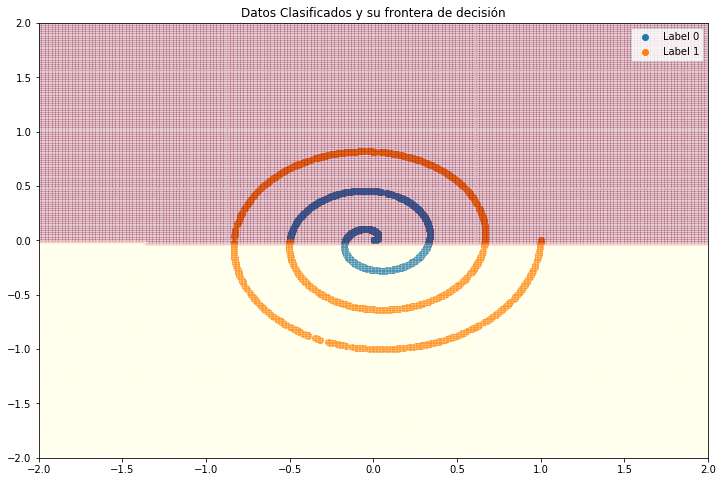

In [19]:
plot_classifier(log_reg1, x_tr1, y_tr1, x_tst1, y_tst1, train_or_test = 'test')

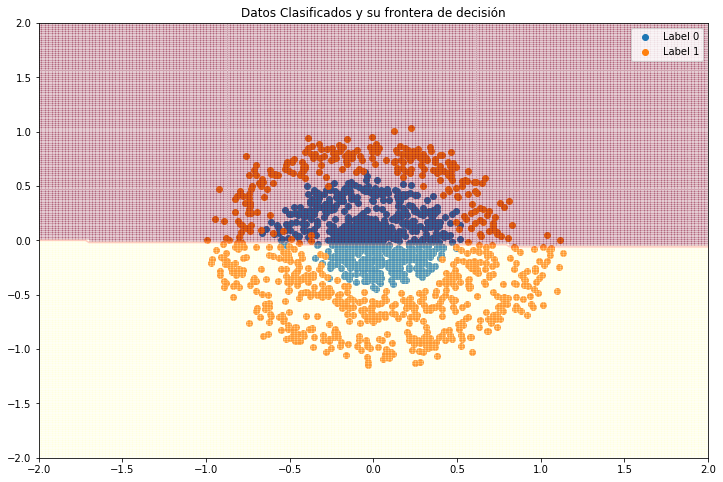

In [20]:
plot_classifier(log_reg2, x_tr2, y_tr2, x_tst2, y_tst2, train_or_test = 'test')

**Comentarios:**
* Se puede ver lo que se habia mencionado, la frontera de decisión de la regresión lineal corresponde a una frontera lineal, la cual pasa por la mitad de los datos. 
* Además, se puede ver que esta decisión no varía si los datos tienen ruido o no. Esto se puede explicar por la forma de los datos (espiral).
* No se puede mejorar el desempeño de un clasificador lineal sin una transformación, dado que los datos claramente no son linealmente separables.
* Si se disminuye el ruido, aumenta un poco la presión, pero nada considerable. Esto se debe porque los putos se distribuyen de forma espiral. Al tener ruido puede que queden mal clasificados y esto disminuya el score, pero es muy similar con ruido o sin este.

Para las siguientes preguntas nos enfocaremos solo en la versión con ruido de los datos, dado que en la práctica es común la existencia de datos con ruido. Probaremos algunos métodos no lineales para ver qué tanto logramos mejorar el desempeño de nuestros datos

In [21]:
# Data a Utilizar
x_tr,x_tst,y_tr,y_tst = do_spiral(n_dots = 5000, ns = 0.08, cf = 6)

### 1.e SVM

Entrene un clasificador SVM con los datos con ruido. ¿Qué forma tiene la frontera de decisión esta vez?

¿Mejoran los resultados al alejarse de los métodos puramente lineales? Comente sobre el desempeño del modelo y su sensibilidad a los parámetros C y gamma, explorando cómo cambia la frontera de decisión al variar estos parámetros.

**Comentarios:**
* Es importante destacar que la SVC por defecto utiliza un kernel 'rbf', este kernel corresponde a un kernel gaussiano con la siguiente forma:
$$ K(\mathbf{x}, \mathbf{x'}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{x'}\|^2}{2\sigma^2}\right)$$
* El parámetro C corresponde al parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C.
* El parámetro gamma corresponde al coeficiente de kernel

In [28]:
# Parámetros Candidatos
C_cand     = np.array([1,10,100,1000])
gamma_cand = np.array([1e-4,1e-3,1e-2, 0.1, 0.2, 0.5])

In [31]:
# Score para los valores candidatos
scores = pd.DataFrame(np.zeros((6,4)),columns=C_cand,index=gamma_cand)
s_min  = float('inf')
s_max  = 0
for i in C_cand:
    for j in gamma_cand:
        SV = SVC(C = i, gamma = j, probability=True)
        SV.fit(x_tr,y_tr)
        pred = SV.predict(x_tst)
        scores.loc[j,i] = accuracy_score(y_tst,pred)
        # mayor y menor estricto por si existe un mismo score para distinto parámetros
        if scores.loc[j,i] > s_max:
            s_max = scores.loc[j,i]; c_max = i; g_max = j
        if scores.loc[j,i] < s_min: 
            s_min = scores.loc[j,i]; c_min = i;  g_min = j

Clasificador ajustado para C: 10 y gamma: 0.0001 con score de: 0.44066666666666665


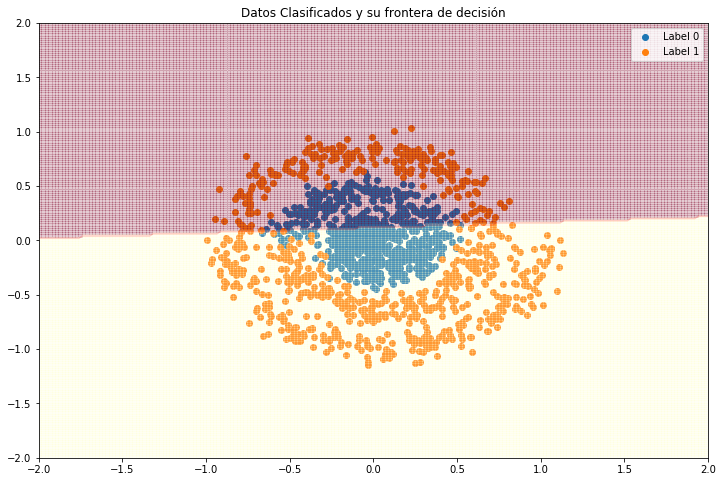

In [32]:
# Frontera de Decisión para mayor score
SV = SVC(C = c_min, gamma = g_min, probability=True)
SV.fit(x_tr,y_tr)
print('Clasificador ajustado para C:',c_min,'y gamma:',g_min,'con score de:',SV.score(x_tst,y_tst))
plot_classifier(SV, x_tr, y_tr, x_tst, y_tst, train_or_test = 'test')

Clasificador ajustado para C: 1000 y gamma: 0.2 con score de: 0.9813333333333333


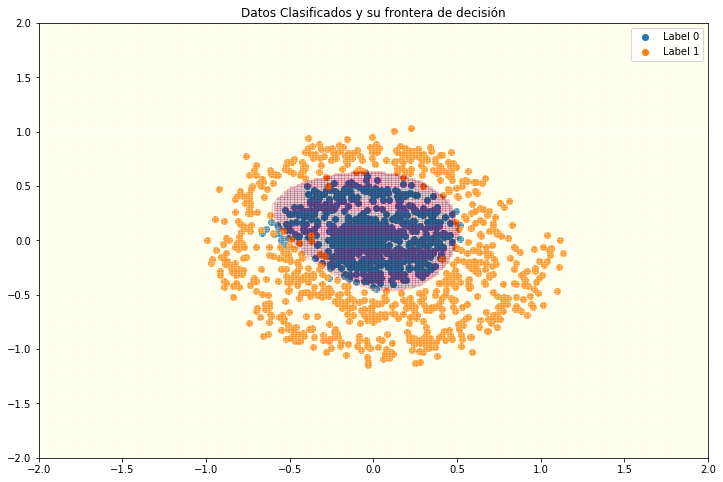

In [33]:
# Frontera de Decisión para mayor score
SV = SVC(C = c_max, gamma = g_max, probability=True)
SV.fit(x_tr,y_tr)
print('Clasificador ajustado para C:',c_max,'y gamma:',g_max,'con score de:',SV.score(x_tst,y_tst))
plot_classifier(SV, x_tr, y_tr, x_tst, y_tst, train_or_test = 'test')

**Comentarios:** se puede ver que los parámetros C y gamma modifican directamente la frontera de decisión.

### Utilizando función GridSearchCV

**Comentarios:** se utilizará la función `GridSearchCV` la cual recorre ciertos valores de parámetros para buscar el mejor estimador. Los parámetros del estimador usados para aplicar al modelo son optimizados mediante Cross Validation.

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [34]:
# Parámetros a evaluar para escontrar el mejor modelo
parameters_svm = [{
    'C'             :  [1,10,100,1000],
    'gamma'         :  [1e-4,1e-3,1e-2, 0.1, 0.2, 0.5]
}]

In [35]:
# Ajustar Modelo
# GridSearchCV(Clasificador, parámetros, Folds CV) Stratified
SVM = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid=parameters_svm, cv=5)
SVM.fit(x_tr,y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Los mejores parámetros para C es 1000 , para gamma 0.5 . Obteniendo un score igual a  0.9813333333333333


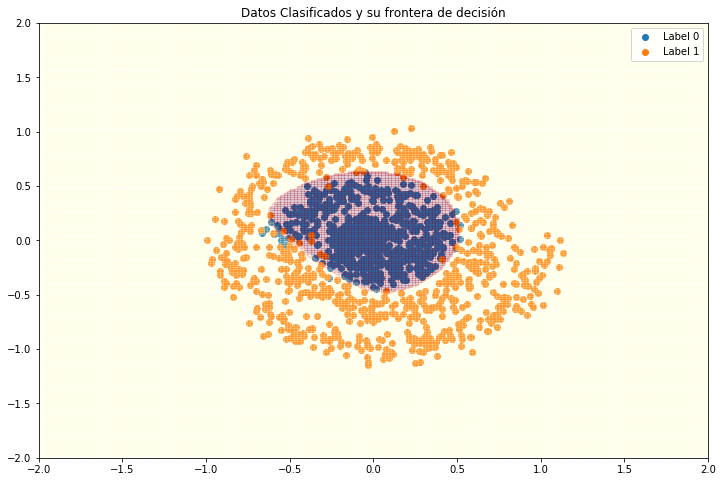

In [36]:
# Entrega el mejor modelo obtenido con CV
best_SVM = SVM.best_params_

# Parámetro n_neighbors
C_best = best_SVM['C']

# Parámetro p
gamma_best = best_SVM['gamma'] 

# Score con el modelo
score = SVM.score(x_tst,y_tst)

# Gráfica de la frontera de decisión
SV = SVC(C = C_best, gamma = gamma_best, probability=True)
SV.fit(x_tr,y_tr)
print('Los mejores parámetros para C es',C_best,', para gamma',gamma_best,'. Obteniendo un score igual a ',score )
plot_classifier(SV, x_tr, y_tr, x_tst, y_tst, train_or_test = 'test')

**Comentarios:** 
* En este caso se puede ver que la frontera de decisión deja de ser lineal y tiene forma según la distribución de puntos de clase 0. 
* Lo anterior implica que el score del ajuste mejora considerablemente para ciertos valores de C y gamma. Esto debido a que el kernel lleva los datos a un espacio donde son linealmente separables, lo cual permite que se puedan solucionar problemas altamente no lineales.
* Por otro lado, se puede ver que el ajuste esta fuertemente relacionado a los valores de C y gamma. Se observa que para una determinada combinación de C y gamma se obtienen scores bastante bajos y esto se traduce en una frontera de decisión similar a una lineal. Mientras que para otra configuración de C y gamma se puede obtener buenos resultados como se pudo ver en el último ajuste.

### 1.f KNN

Pruebe ahora con otro método no lineal, K Nearest Neighbors o KNN. Discuta sus resultados y la frontera de decisión que encuentra el modelo.

Realice un Cross Validation sobre el parámetro "n_neighbors' o 'p' (o ambos usando un mallado) y comente si mejoran significativamente los resultados. Puede apoyarse de los códigos de la tarea 1 para realizar el Cross Validation. ¿Qué representan estos parámetros para el método?

**Comentarios:** parámetros del método
* N_neighbors  : corresponde al número de vecinos que se consideran para la clasificación.
* P            : parámetro de potencia para la métrica de distancia. Cuando es 2 corresponde a usar la distancia euclidiana.

In [37]:
nn_candidato =  np.array([2,3,4,5,6,7,8,9,10])
p_candidato  =  np.array([1,2,3,4,5])
score        =  []
folds        =  StratifiedKFold(5)
score_actual =  0


for i in nn_candidato:
    for j in p_candidato:
        score_fold = []
        for train_index, val_index in folds.split(x_tr,y_tr):
            y_tr_fold  = y_tr[train_index]
            y_val_fold = y_tr[val_index]
            x_tr_fold  = x_tr[train_index]
            x_val_fold = x_tr[val_index]
            
            # Ajuste
            KNN = KNeighborsClassifier(n_neighbors=i, p=j)
            KNN.fit(x_tr_fold,y_tr_fold)
            pred_fold  = KNN.predict(x_val_fold)
            score_fold = accuracy_score(y_val_fold, pred_fold)
        if np.mean(score_fold) > score_actual:
            score_actual = np.mean(score_fold)
            nn_best      = i
            p_best       = j
print('Los mejores parámetros son NN',nn_best,'y p',p_best,'obteniendo un score de',score_actual)

Los mejores parámetros son NN 6 y p 1 obteniendo un score de 0.9842857142857143


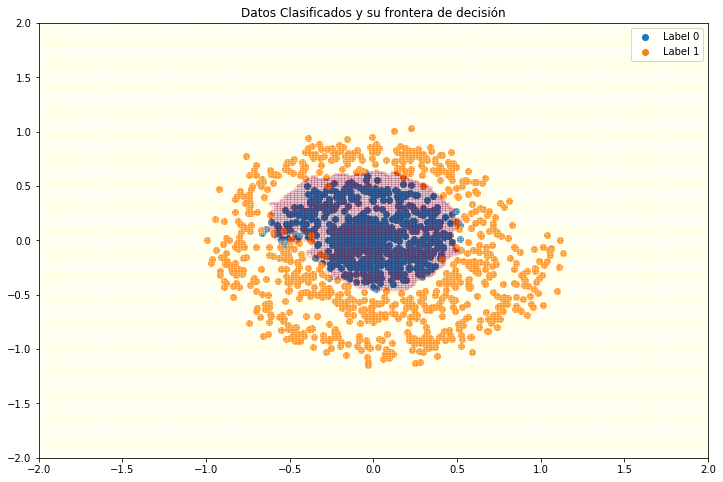

In [38]:
# Gráfica de frontera de decisión
KNN = KNeighborsClassifier(n_neighbors=nn_best, p=p_best)
KNN.fit(x_tr,y_tr)
plot_classifier(KNN,x_tr,y_tr,x_tst,y_tst,train_or_test='test')

### Utilizando función GridSearchCV

In [39]:
# Parámetros a evaluar para escontrar el mejor modelo
parameters_knn = [{
    'n_neighbors' :  [2,3,4,5,6,7,8,9,10],
    'p'           :  [1,2,3,4,5]
}]

In [40]:
# Ajustar Modelo
# GridSearchCV(Clasificador, parámetros, Folds CV) Stratified
KNN = GridSearchCV(KNeighborsClassifier(), param_grid = parameters_knn, cv = 5 )
KNN.fit(x_tr,y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
# Entrega el mejor modelo obtenido con CV
best_KNN = KNN.best_params_

# Parámetro n_neighbors
n_neighbors = best_KNN['n_neighbors']

# Parámetro p
p = best_KNN['p'] 

# Score con el modelo
KNN.score(x_tst,y_tst)

0.982

Clasificador ajustado para n_neighbors: 5 y p: 1 con score de: 0.982


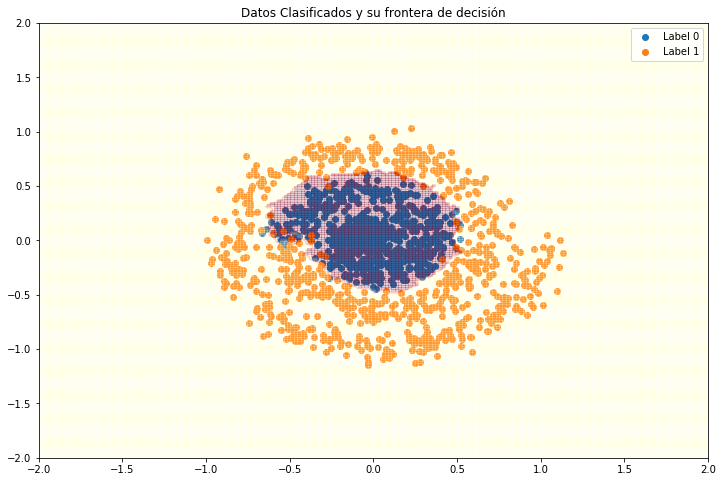

In [43]:
# Gráfico sobre la frontera de decisión
print('Clasificador ajustado para n_neighbors:',n_neighbors,'y p:',p,'con score de:',KNN.score(x_tst,y_tst))
plot_classifier(KNN,x_tr,y_tr,x_tst,y_tst,train_or_test='test')

**Comentarios:**
* Se puede ver que de igual manera al caso anterior, se obtienes buenos resultados y una frontera de decisión muy similar al caso de la C-SVM. 
* El score obtenido con este método, es prácticamente al caso de la C-SVM. 
* Además, se puede ver que se obtienen parámetros muy similares si se utiliza el comando `GridSearchCV` y si se realiza crossvalidation de forma manual. Con una pequeña diferencia en el parámetro N_neighbors, pero no así en el score.

### 1.g

Del mejor modelo obtenido en el punto anterior, grafique los datos de test coloreando de manera diferente los puntos mal clasificados por su modelo. ¿Por qué el modelo no logra clasificar bien estos puntos?¿Qué habría ocurrido si estuvieramos utilizando los datos sin ruido?

_Se utilizará el conjunto de test_

In [44]:
# Cálculo de los indices bien clasificados
pred          =  KNN.predict(x_tst) 
indice_true   =  []
indice_false  =  []
for i in range(len(y_tst)):
    if pred[i] == y_tst[i]:
        indice_true.append(i)
    else: 
        indice_false.append(i)

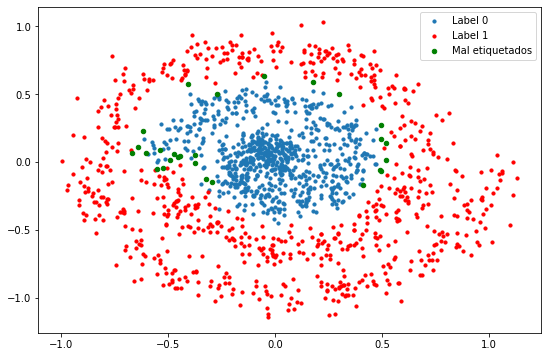

In [45]:
#Gráfico
plt.figure(figsize=(9,6))

# Gráfica Training Set
plt.scatter(x_tst[y_tst == 0][:,0],x_tst[y_tst == 0][:,1], label = 'Label 0', s=10)
plt.scatter(x_tst[y_tst == 1][:,0],x_tst[y_tst == 1][:,1],c='r', label = 'Label 1', s=10) 
plt.scatter(x_tst[indice_false][:,0],x_tst[indice_false][:,1], c='g', label = 'Mal etiquetados', s=20)
plt.legend()

**Comentarios**:
* Se puede apreciar que los datos mal clasificados están en las cercanias de la frontera de decisión. 
* Lo anterior, se puede explicar debido a que los outliers para una SVM corresponden a los puntos cerca de la frontera de decisión, caso contrario a un problema de regresión. 
* Además, estos puntos corresponden a outliers producto del ruido. 

###  Aplicando KNN para los datos sin ruidos

In [47]:
# Ajuste 
KNN_snoise = GridSearchCV(KNeighborsClassifier(), param_grid = parameters_knn, cv = 5 )
KNN_snoise.fit(x_tr1,y_tr1)
pred_snoise = KNN_snoise.predict(x_tst1)

Ajusta la data sin ruido para los parámetros NN 2 y p 1 se tiene un score de 1.0


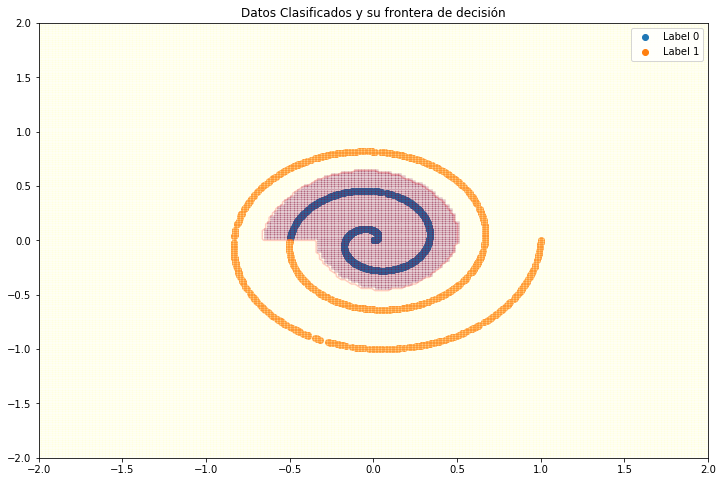

In [50]:
# Entrega el mejor modelo obtenido con CV
best_KNN_snoise = KNN_snoise.best_params_

# Parámetro n_neighbors
n_neighbors_snoise = best_KNN_snoise['n_neighbors']

# Parámetro p
p_snoise = best_KNN_snoise['p'] 

# Score con el modelo
score_snoise = KNN_snoise.score(x_tst1,y_tst1)

print('Ajusta la data sin ruido para los parámetros NN',n_neighbors_snoise,'y p',p_snoise, 'se tiene un score de',score_snoise)

# Gráfico frontera de decisión
plot_classifier(KNN_snoise,x_tr1,y_tr1,x_tst1,y_tst1,train_or_test='test')

**Comentarios:**
* Al comparar los datos sin ruido vs los datos con ruido, se puede ver que los datos mal clasificados en el punto anterior fueron productos del ruido. Ver score

### 1.h Método Kernel

Utilizaremos Kernel Gaussiano para preprocesar los datos, pasando implícitamente por un espacio altamente dimensional (más específicamente por un manifold de un espacio inifinito dimensional), obteniendo una representación lo más linealmente separable posible.

Ajuste el kernel y transforme los datos. Grafique los puntos transformados y comente qué realiza el modelo. Varíe luego el valor de gamma para tratar de entender qué influencia tiene sobre la separabilidad de los puntos transformados.¿Le parece un buen método para este problema?

Usando algún valor de gamma que le parezca adecuado, ajuste un modelo de regresión logística sobre los datos transformados. ¿Mejora el desempeño del modelo respecto a la versión original? ¿Se logra aumentar la separabilidad lineal de los datos efectivamente? apoyese de gráficos y métricas adecuadas. Utilice una matriz de confusión para este análisis.

In [56]:
# Ajuste del kernel
ker = KernelPCA(2,kernel = 'rbf', gamma=5)
ker.fit(x_tr)
x_tr_ker  = ker.transform(x_tr)
x_tst_ker = ker.transform(x_tst)

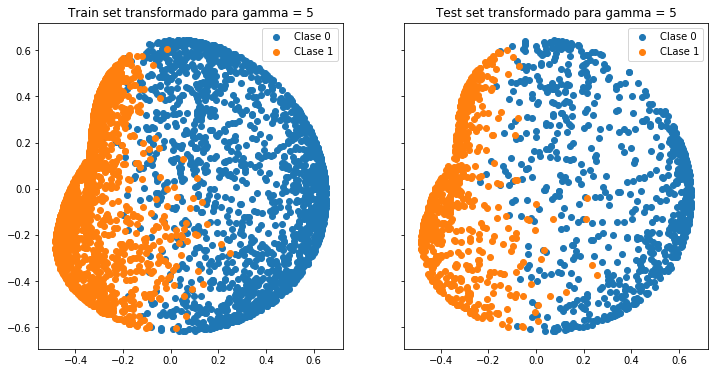

In [57]:
# Gráfico de datos transformados por kernel
ig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True,sharex=True)

# Gráfica Training Set
axs[0].scatter(x_tr_ker[y_tr == 0][:,0],x_tr_ker[y_tr == 0][:,1])
axs[0].scatter(x_tr_ker[y_tr == 1][:,0],x_tr_ker[y_tr == 1][:,1]) 
    
# Gráfica Test Set
axs[1].scatter(x_tst_ker[y_tst == 0][:,0],x_tst_ker[y_tst == 0][:,1])
axs[1].scatter(x_tst_ker[y_tst == 1][:,0],x_tst_ker[y_tst == 1][:,1])
    
# Leyenda por etiqueta
axs[0].set_title("Train set transformado para gamma = 5")
axs[0].legend(['Clase 0','CLase 1'])
axs[1].set_title("Test set transformado para gamma = 5")
axs[1].legend(['Clase 0','CLase 1'])

**Comentarios:**
* Se puede notar que la transformación de los datos permite separarlos linealmente. Por lo tanto, se espera que al ajustar la data transformada, por ejemplo, por una regresión logística se obtenga un buen score.
* La función KernelPCA tiene como entrada el número de componentes (2), el kernel a utilizar ('rbf'=gaussiano), gamma es el coeficiente del kernel.

In [58]:
# Ajuste para gamma 1
ker1 = KernelPCA(2,kernel = 'rbf', gamma=1)
ker1.fit(x_tr)
x_tr_ker1 = ker1.transform(x_tr)

# Ajuste para gamma 10
ker2 = KernelPCA(2,kernel = 'rbf', gamma=10)
ker2.fit(x_tr)
x_tr_ker2 = ker2.transform(x_tr)

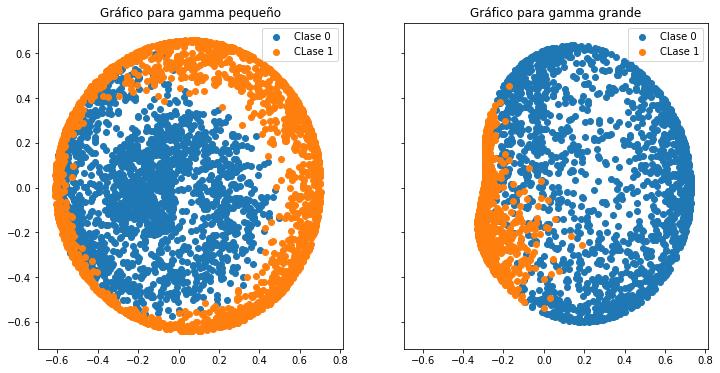

In [59]:
# Gráfico comparativo de la variación de gamma
ig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True,sharex=True)

# Gráfica Training Set
axs[0].scatter(x_tr_ker1[y_tr == 0][:,0],x_tr_ker1[y_tr == 0][:,1])
axs[0].scatter(x_tr_ker1[y_tr == 1][:,0],x_tr_ker1[y_tr == 1][:,1]) 
    
# Gráfica Test Set
axs[1].scatter(x_tr_ker2[y_tr == 0][:,0],x_tr_ker2[y_tr == 0][:,1])
axs[1].scatter(x_tr_ker2[y_tr == 1][:,0],x_tr_ker2[y_tr == 1][:,1])
    
# Leyenda por etiqueta
axs[0].set_title("Gráfico para gamma pequeño")
axs[0].legend(['Clase 0','CLase 1'])
axs[1].set_title("Gráfico para gamma grande")
axs[1].legend(['Clase 0','CLase 1'])

**Comentarios:** se puede apreciar que el valor de gamma controla la distribución de los datos. Es importante señalar que se necesita encontrar un valor de gamma intermedio para que sea linealmente separable, como es el caso de gamma = 5.

In [60]:
# Ajustar regresión logistica para gamma = 5
log_ker = LogisticRegression()
log_ker.fit(x_tr_ker,y_tr)
score = log_ker.score(x_tst_ker,y_tst)

La regresión logística tiene un score de 0.9673333333333334 para datos ajustados por kernel gaussiano


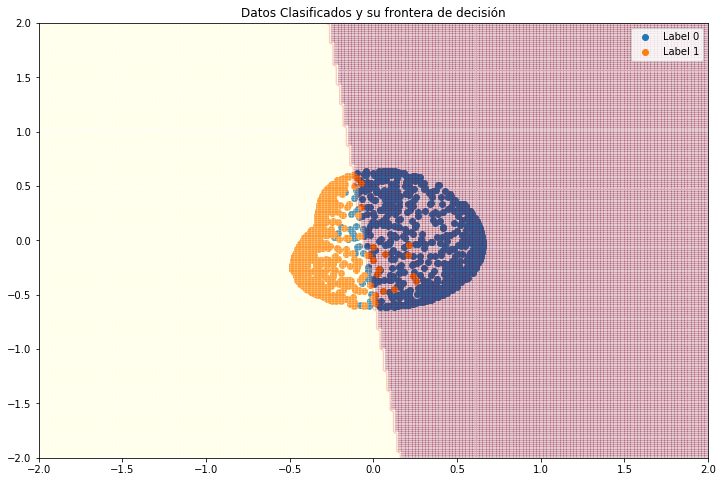

In [61]:
# Gráfico de frontera de decisión para logistic regression
print('La regresión logística tiene un score de',score, 'para datos ajustados por kernel gaussiano')
plot_classifier(log_ker, x_tr_ker, y_tr, x_tst_ker, y_tst, train_or_test = 'test')

**Comentarios:** gracias a la transformación que se hizo mediante el kernelPCA se pudo mejorar el rendimiento de la regresión logística al ser los datos linealmente separables.

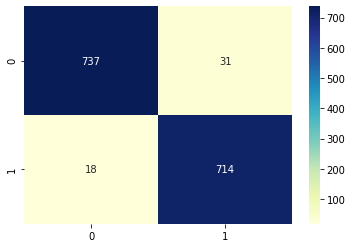

In [62]:
# Matriz de confusión
confusion_matrix = metrics.confusion_matrix(y_tst, log_ker.predict(x_tst_ker))
sns.heatmap(confusion_matrix, annot = True, fmt = 'd',cmap="YlGnBu")
plt.show()

**Comentarios:** la matriz de confusión muestra la clasificación realizada por la regresión. Se puede ver que los ejemplos clasificados de manera correcta son ampliamente mayor que los mal clasificados. 

### 1.i Manualmente

Como nosotros conocemos cómo se generaron los datos tenemos una ventaja sobre los modelos. Genere una transformación de los datos que estime conveniente para obtener datos linealmente separables. Puede aumentar o disminuir la dimensión a gusto, por ejemplo puede realizar algo del estilo $(x,y)\longrightarrow (x+y)$, ó $(x,y)\longrightarrow (x,y,x+y,x-y)$. Apoyese de las características geométricas del conjunto de datos y justifique sus elecciones con gráficos adecuados.

Luego, entrene un regresor logístico sobre sus datos transformados y comente sobre la utilidad de conocer cómo se generaron los datos. Grafique los datos transformados o alguna proyección de ellos junto con la frontera de decisión y comente sobre lo que realiza su transformación.

### Transformación de los datos 1

La transformación que se utilizará corresponde a 
$$K:\mathbb{R}^2 \longrightarrow \mathbb{R}$$
$$(x,y)\longrightarrow (x+y)$$

In [88]:
# Creando nuevo train set
x1_tr = x_tr[:,0]+x_tr[:,1]
x_tr_trans2 = np.vstack((x1_tr))
 
# Creando nuevo test set
x1_tst = x_tst[:,0]+x_tst[:,1]
x_tst_trans2 = np.vstack((x1_tst))

In [89]:
log_trans = LogisticRegression()
log_trans.fit(x_tr_trans2,y_tr)
score = log_trans.score(x_tst_trans2,y_tst)
print('Gráfico de dispersión de data transformada. Score igual a',score,' ajustada mediante LogisticRegression')

Gráfico de dispersión de data transformada. Score igual a 0.5793333333333334  ajustada mediante LogisticRegression


### Transformación de los datos 2

La transformación que se utilizará corresponde a 
$$K:\mathbb{R}^2 \longrightarrow \mathbb{R}^4$$
$$(x,y)\longrightarrow (x,y,x+y,x-y)$$

In [76]:
# Creando nuevo train set
x1_tr = x_tr[:,0]
x2_tr = x_tr[:,1]
x3_tr = x1_tr+x2_tr
x4_tr = x1_tr-x2_tr

# Nuevo Train set
x_tr_trans1 = np.vstack((x1_tr,x2_tr,x3_tr,x4_tr)).T  

# Creando nuevo test set
x1_tst = x_tst[:,0]
x2_tst = x_tst[:,1]
x3_tst = x1_tst+x2_tst
x4_tst = x1_tst-x2_tst

# Nuevo test set
x_tst_trans1 = np.vstack((x1_tst,x2_tst,x3_tst,x4_tst)).T  

In [82]:
# Ajuste por regresión logistica
log_trans = LogisticRegression()
log_trans.fit(x_tr_trans1,y_tr)
score = log_trans.score(x_tst_trans1,y_tst)
print('Gráfico de dispersión de data transformada. Score igual a',score,' ajustada mediante LogisticRegression')

Gráfico de dispersión de data transformada. Score igual a 0.6606666666666666  ajustada mediante LogisticRegression


### Transformación de los datos 3

Se tiene que 
$$x_1 = R(\text{n_dots})\cdot \cos(\theta)$$
$$x_2 = R(\text{n_dots})\cdot \sin(\theta)$$
Sumando y elevando al cuadrado ambas ecuaciones se tiene 
$$x_1^2+x_2^2=R(\text{n_dots})^2\cdot \cos(\theta)^2+R(\text{n_dots})^2\cdot \sin(\theta)^2$$
$$x_1^2+x_2^2 = R(\text{n_dots})^2$$
Por lo tanto, la transformación que se utilizará corresponde a 
$$K:\mathbb{R}^2 \longrightarrow \mathbb{R}^3$$
$$(x,y)\longrightarrow (x,y,x^2+y^2)$$

**Datos sin ruido**

In [66]:
# Creando nuevo train set
x1_tr = x_tr1[:,0]
x2_tr = x_tr1[:,1]
x3_tr = x1_tr**2+x2_tr**2

# Nuevo Train set
x_tr_trans = np.vstack((x1_tr,x2_tr,x3_tr)).T  

# Creando nuevo test set
x1_tst = x_tst1[:,0]
x2_tst = x_tst1[:,1]
x3_tst = x1_tst**2+x2_tst**2

# Nuevo test set
x_tst_trans = np.vstack((x1_tst,x2_tst,x3_tst)).T  

In [68]:
# Ajuste por regresión logistica
log_trans = LogisticRegression()
log_trans.fit(x_tr_trans,y_tr1)
score = log_trans.score(x_tst_trans,y_tst1)

Gráfico de dispersión de data transformada. Score igual a 0.9926666666666667  ajustada mediante LogisticRegression


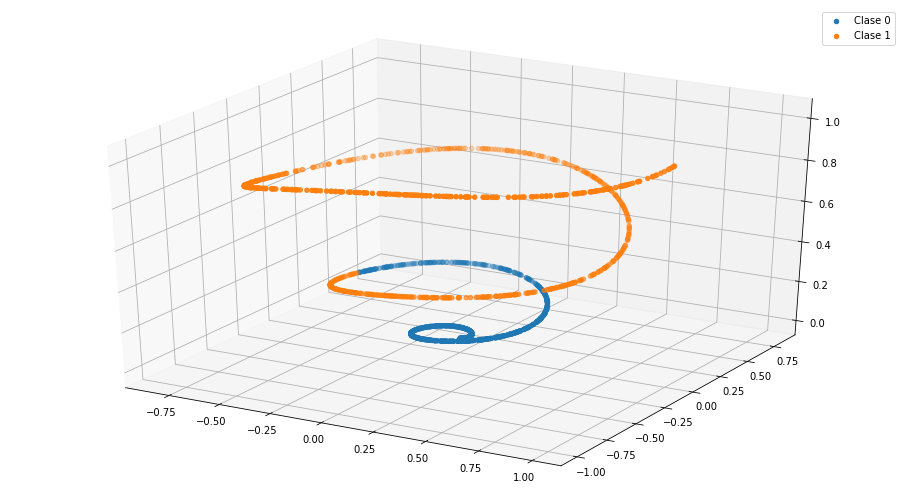

In [69]:
# Gráfico de nueva data
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(x_tst_trans[y_tst1==0][:,0],x_tst_trans[y_tst1==0][:,1],x_tst_trans[y_tst1==0][:,2], label='Clase 0')
ax.scatter(x_tst_trans[y_tst1==1][:,0],x_tst_trans[y_tst1==1][:,1],x_tst_trans[y_tst1==1][:,2], label='Clase 1')
ax.legend()

print('Gráfico de dispersión de data transformada. Score igual a',score,' ajustada mediante LogisticRegression')
plt.show()

**Datos con ruido**

In [78]:
# Creando nuevo train set
x1_tr = x_tr[:,0]
x2_tr = x_tr[:,1]
x3_tr = x1_tr**2+x2_tr**2

# Nuevo Train set
x_tr_trans = np.vstack((x1_tr,x2_tr,x3_tr)).T  

# Creando nuevo test set
x1_tst = x_tst[:,0]
x2_tst = x_tst[:,1]
x3_tst = x1_tst**2+x2_tst**2

# Nuevo test set
x_tst_trans = np.vstack((x1_tst,x2_tst,x3_tst)).T  

In [79]:
# Ajuste por regresión logistica
log_trans = LogisticRegression()
log_trans.fit(x_tr_trans,y_tr)
score = log_trans.score(x_tst_trans,y_tst)

Gráfico de dispersión de data transformada. Score igual a 0.972  ajustada mediante LogisticRegression


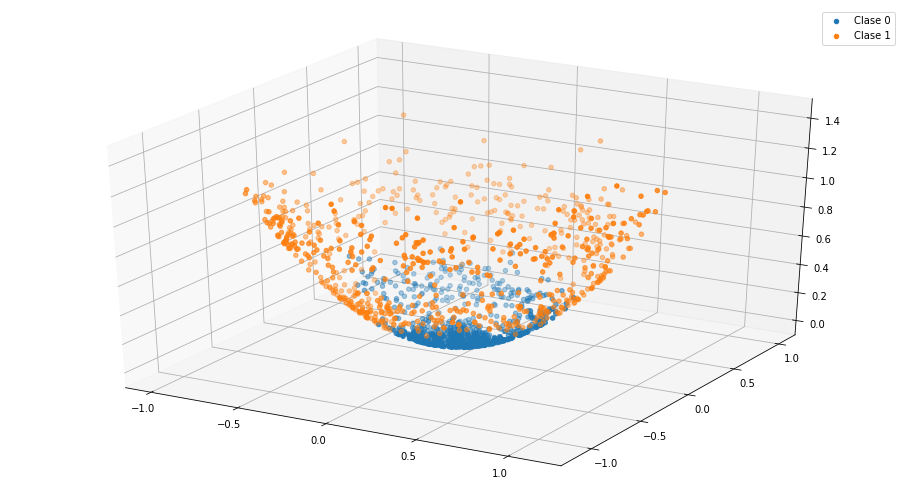

In [80]:
# Gráfico de nueva data
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(x_tst_trans[y_tst==0][:,0],x_tst_trans[y_tst==0][:,1],x_tst_trans[y_tst==0][:,2], label='Clase 0')
ax.scatter(x_tst_trans[y_tst==1][:,0],x_tst_trans[y_tst==1][:,1],x_tst_trans[y_tst==1][:,2], label='Clase 1')
ax.legend()

print('Gráfico de dispersión de data transformada. Score igual a',score,' ajustada mediante LogisticRegression')
plt.show()

**Comentarios:** 
* Al igual que en casos anteriores, en la data sin ruido se obtuvo mejor score que en la data con ruido por lo ya mencionado.
* Por otro lado, la transformación manual permite que sea más fácil para una regresión logística clasificar los datos, la frontera de decisión tiene otra dimensión para ajustarse.
* Por último, se puede ver que la mejor transformación es la 3, esto gracias a conocer como se conformaron los datos y aprovecharse de las propiedades de esto. 